In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt #data plotting and visualisation
import seaborn as sns #data plotting and visualisation

import opendatasets as od #to download dataset
od.download("https://www.kaggle.com/datasets/kartik2112/fraud-detection")

Skipping, found downloaded files in ".\fraud-detection" (use force=True to force download)


In [58]:
#loading train and test data

train = pd.read_csv("fraud-detection/fraudTrain.csv")
test = pd.read_csv("fraud-detection/fraudTest.csv")
print(train.head(3))

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   

                          merchant       category     amt      first     last  \
0       fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer    Banks   
1  fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie     Gill   
2             fraud_Lind-Buckridge  entertainment  220.11     Edward  Sanchez   

  gender                        street  ...      lat      long  city_pop  \
0      F                561 Perry Cove  ...  36.0788  -81.1781      3495   
1      F  43039 Riley Greens Suite 393  ...  48.8878 -118.2105       149   
2      M      594 White Dale Suite 530  ...  42.1808 -112.2620      4154   

                                 job         dob  \
0          Psychologist, counselling  1988-03-09   
1  Special educational needs teacher 

In [59]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [60]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt 
to_drop = ['Unnamed: 0','cc_num','city','state','street','city_pop','is_fraud','unix_time','zip'] #these columns will be dropped
to_encode = ["merchant","category","first","last","gender","job"] #these columns will be label encoded
encoder = LabelEncoder()

In [61]:
#dropping and encoding train and test data

train_x = train.drop(to_drop,axis=1)
train_x[to_encode] = train_x[to_encode].apply(encoder.fit_transform)
train_x[to_encode] = train_x[to_encode].astype('category')
test_x = test.drop(to_drop,axis=1)
test_x[to_encode] = test_x[to_encode].apply(encoder.fit_transform)
test_x[to_encode] = test_x[to_encode].astype('category')

In [62]:
def preprocess(data_x):

    #dob converted to column of year
    data_x['dob'] = pd.to_datetime(data_x['dob'],dayfirst=False)
    data_x['dob year'] = data_x['dob'].dt.year.astype(int)
    data_x = data_x.drop(['dob'],axis=1)

    #transaction date and time converted to four columns of year,month,day and hour
    data_x['trans_date_trans_time'] = pd.to_datetime(data_x['trans_date_trans_time'],dayfirst=False)
    data_x['trans year'] = data_x['trans_date_trans_time'].dt.year.astype(int)
    data_x['trans month'] = data_x['trans_date_trans_time'].dt.month.astype(int)
    data_x['trans day'] = data_x['trans_date_trans_time'].dt.day.astype(int)
    data_x['trans hour'] = data_x['trans_date_trans_time'].dt.hour.astype(int)
    data_x = data_x.drop(['trans_date_trans_time'],axis=1)
    
    return data_x

In [63]:
#preprocessing train data
train_x = preprocess(train_x)
train_x = train_x.set_index("trans_num")
train_y = train['is_fraud']
print(train_x[0:3])

#preprocessing test data
test_x = preprocess(test_x)
test_x = test_x.set_index("trans_num")
test_y = test['is_fraud']
print(test_x[0:3])

                                 merchant category     amt first last gender  \
trans_num                                                                      
0b242abb623afc578575680df30655b9      514        8    4.97   162   18      0   
1f76529f8574734946361c461b024d99      241        4  107.23   309  157      0   
a1a22d70485983eac12b5b88dad1cf95      390        0  220.11   115  381      1   

                                      lat      long  job  merch_lat  \
trans_num                                                             
0b242abb623afc578575680df30655b9  36.0788  -81.1781  370  36.011293   
1f76529f8574734946361c461b024d99  48.8878 -118.2105  428  49.159047   
a1a22d70485983eac12b5b88dad1cf95  42.1808 -112.2620  307  43.150704   

                                  merch_long  dob year  trans year  \
trans_num                                                            
0b242abb623afc578575680df30655b9  -82.048315      1988        2019   
1f76529f8574734946361c461b024d99 

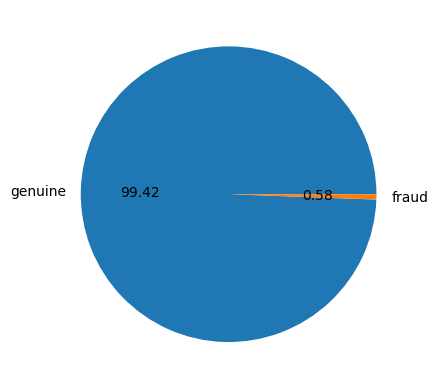

In [64]:
#displaying percentage of fraud cases

data = train_y.value_counts()
plt.pie(data,labels=['genuine','fraud'],autopct='%.2f')
plt.show()

In [65]:
#Using SMOTE to balance the data

from imblearn.over_sampling import SMOTE
train_x,train_y = SMOTE(sampling_strategy=0.5,random_state=24).fit_resample(train_x,train_y)
print(train_y.value_counts())

is_fraud
0    1289169
1     644584
Name: count, dtype: int64


In [66]:
#libraries for training and evaluation

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,roc_auc_score,confusion_matrix

In [67]:
#models to be evaluated

DT = DecisionTreeClassifier(random_state=24)
RF = RandomForestClassifier(n_estimators=15,random_state=24)

In [68]:
def evaluate(model):
    model.fit(train_x,train_y)
    pred_y = model.predict(test_x)
    prob_y = model.predict_proba(test_x)[:,1]

    #scores
    print("precision : ",precision_score(test_y,pred_y))
    print("recall : ",recall_score(test_y,pred_y))
    print("F1_score : ",f1_score(test_y,pred_y))
    print("ROC_AUC : ",roc_auc_score(test_y,pred_y))

    #confusion matrix based on predicted class
    matrix = confusion_matrix(test_y, pred_y)
    sns.heatmap(matrix,annot=True)
    plt.title("Confusion Matrix")
    plt.show()

    #ROC-curve based on probability of classes
    fpr, tpr, threshold = roc_curve(test_y, prob_y)
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC curve")
    plt.show()

Decision Tree Classifier : -
precision :  0.6937422295897223
recall :  0.7804195804195804
F1_score :  0.7345326897762177
ROC_AUC :  0.8895423094393783


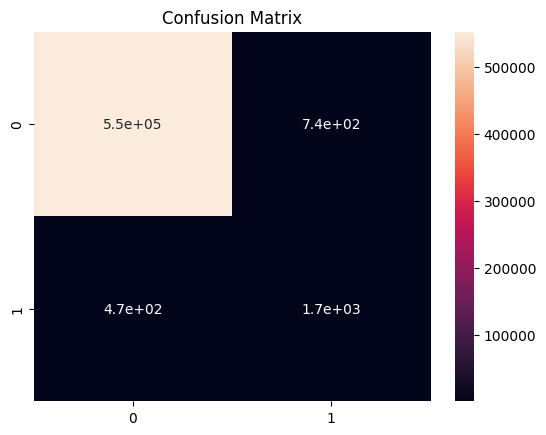

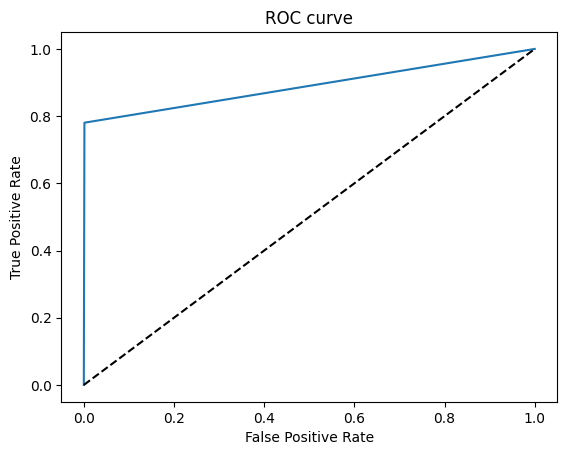

In [69]:
print("Decision Tree Classifier : -")
evaluate(DT)

Random Forest Classifier : -
precision :  0.9479166666666666
recall :  0.7212121212121212
F1_score :  0.8191686523696055
ROC_AUC :  0.8605292867691392


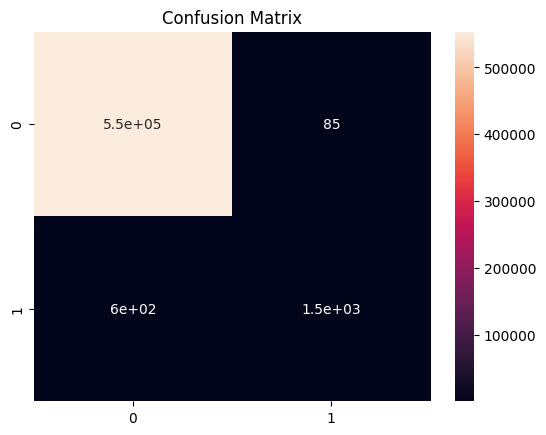

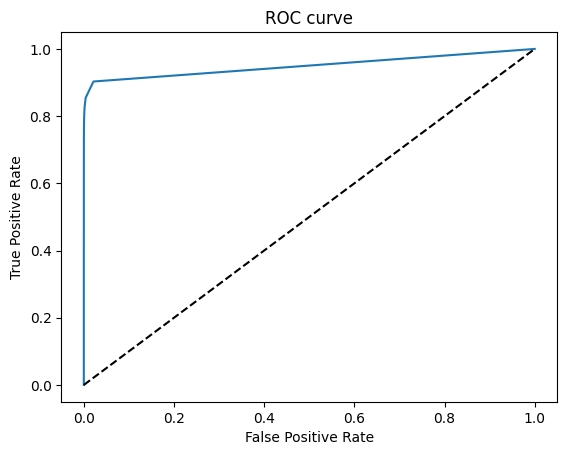

In [70]:
print("Random Forest Classifier : -")
evaluate(RF)